# September 29, 2022: Reimplement Najafi et al. 2017
I have the trial level responses for Emoprox2 paradigm. Mashid analysed Emoprox1 paradigm, and her ISC matrices were visually distinct for Approach and Retreat segments. Here I am replicating her results and seeing how similar are my matrices with her's.

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random
import csv
from copy import deepcopy

from brainiak.isc import (
    compute_correlation
)

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.APPR = 1
args.RETR = -1
args.LABELS = [args.APPR, args.RETR]
args.LABEL_NAMES = ['APPR', 'RETR']
args.NAMES = ['APPR', 'RETR']
args.TRIAL_LEN = 12
args.MIN_TRS = {'APPR': 7, 'RETR': 5}
args.MIN_TRIALS = {name:7 for name in args.LABEL_NAMES}
args.near_miss_thresh = 0.7
args.near_miss_width = 8
args.window_shift = 3
APPR = np.arange(0, 7) - args.window_shift
RETR = np.arange(7, 12) - args.window_shift
args.SEGMENT_TRS = {'APPR': APPR, 'RETR': RETR}
args.TR = 1.25

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


  0%|          | 0/30 [00:00<?, ?it/s]

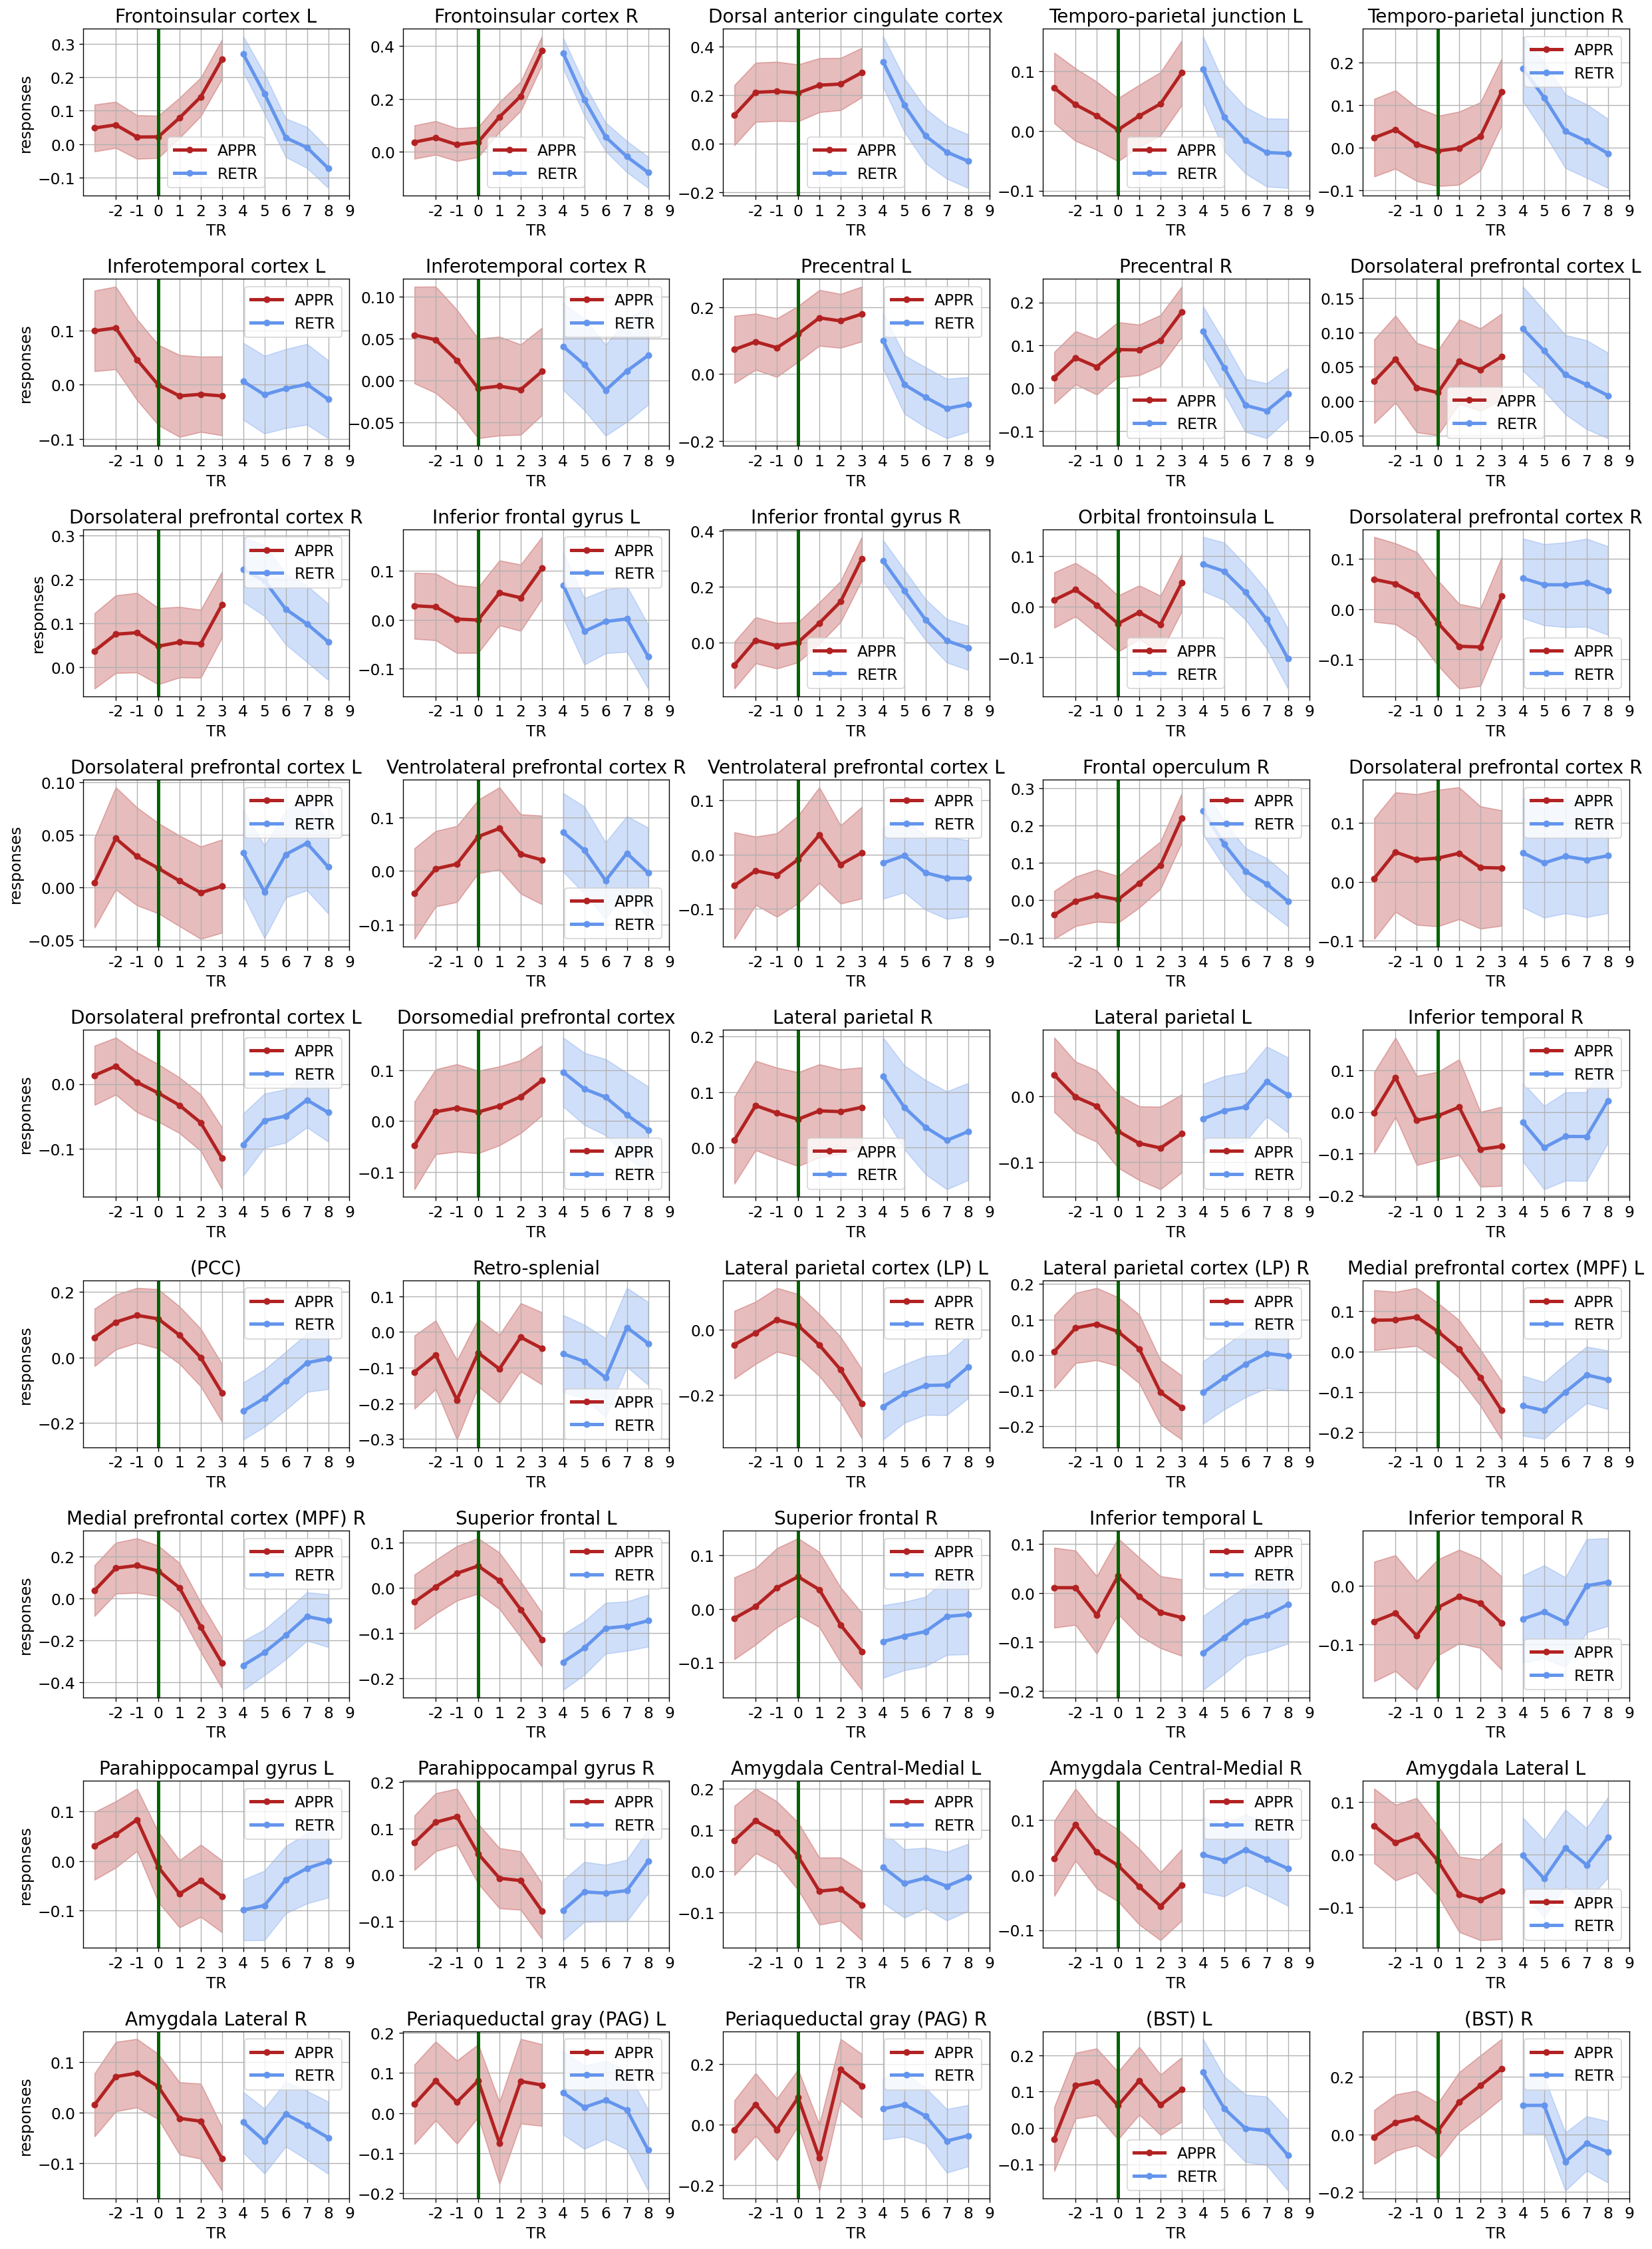

In [3]:
args.proj_dir = proj_dir

with open(
    f"/home/joyneelm/FORAGING/local/notebooks/dynamical_systems_emoprox/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)
# motion_df

args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/emoprox2/data/rois_{args.roi_set_name}"
)

# exploratory data
args.subjects = np.unique(motion_df.pid.values)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

# condition responses
X = dataset_utils.get_emo2_trial_level_responses(args, motion_df)
args.plot_colors = {'APPR': 'firebrick', 'RETR': 'cornflowerblue'}
dataset_utils.plot_emo2_responses_v2(args, X)

In [4]:
# time series per subject; trial wise reponse for a given TR
def get_block_time_series(args, X):
    ts = {}
    for name in X.keys():
        for idx_time in range(args.MIN_TRS[name]):
            block = f"{name}_TR{idx_time}"
            ts[block] = []
            for x in X[name]:
                if len(x) < args.MIN_TRIALS[name]: continue
                ts[block].append(x[:args.MIN_TRIALS[name], idx_time, :])
            ts[block] = np.stack(ts[block], axis=-1)
    return ts

ts = get_block_time_series(args, X)

In [5]:
ts.keys()
ts['APPR_TR0'].shape

(7, 45, 30)

In [6]:
# ISC
def get_iscs(args, ts):
    ensure_symmetry = lambda A: (A + A.T)/2 # projection onto the space of symmetric matrices
    
    isfcs = {}; pos_isfcs = {}
    for block in ts.keys():
        ts_block = np.rollaxis(ts[block], 2, 0)
        isfcs[block] = []
        pos_isfcs[block] = []
        for idx_subj in range(ts_block.shape[0]):
            isfc_subj = compute_correlation(
                np.ascontiguousarray(ts_block[idx_subj].T),
                np.ascontiguousarray(
                    np.nanmean(
                        np.delete(ts_block, idx_subj, axis=0),
                        axis=0
                    ).T
                ),
                return_nans=True
            )
            isfcs[block].append(isfc_subj)

            isfc_subj = (isfc_subj > 0) * isfc_subj
            pos_isfcs[block].append(isfc_subj)

        isfcs[block] = np.stack(isfcs[block], axis=-1)
        isfcs[block] = np.nanmean(isfcs[block], axis=-1)
        isfcs[block] = ensure_symmetry(isfcs[block])

        pos_isfcs[block] = np.stack(pos_isfcs[block], axis=-1)
        pos_isfcs[block] = np.nanmean(pos_isfcs[block], axis=-1)
        pos_isfcs[block] = ensure_symmetry(pos_isfcs[block])
    return isfcs, pos_isfcs

iscs, pos_iscs = get_iscs(args, ts)

In [7]:
iscs['APPR_TR0'].shape

(45, 45)

In [8]:
def get_min_max(d):
    '''
    min and max values of the matrices:
    used in plotting the matrices
    '''
    vals = []
    for block in d.keys():
        vals.append(d[block])
    vals = np.concatenate(vals, axis=0).flatten()
    vmin = np.nanquantile(vals, q=0.05)
    vmax = np.nanquantile(vals, q=0.95)
    return -max(-vmin, vmax), max(-vmin, vmax)

def set_plot_ticks(args, ax):
    ax.set_yticks(args.major_ticks, args.major_tick_labels, rotation=0, va='center')
    ax.set_xticks(args.major_ticks, args.major_tick_labels, rotation=90, ha='center')

    ax.set_yticks(args.minor_ticks-0.5, minor=True)
    ax.set_xticks(args.minor_ticks-0.5, minor=True)
    ax.tick_params(
        which='major', direction='out', length=5.5, 
        # grid_color='white', grid_linewidth='1.5',
        labelsize=10,
    )
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)


def plot_iscs(args, iscs, cmap=cmr.iceburn):
    vmin, vmax = get_min_max(iscs)

    nrows, ncols = max(list(args.MIN_TRS.values())), len(args.NAMES) + 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=0.65, hspace=0.65
    )

    for idx_block, block in enumerate(iscs.keys()):
        name = block.split('_')[0]
        tr = int(block.split('_')[1][-1])
        col = args.NAMES.index(name)
        ax = axs[tr, col]

        # if block == 'safe_early': continue

        im = ax.imshow(
            iscs[block], #* rois[block], 
            cmap=cmap, 
            vmin=vmin, vmax=vmax
            # vmin=0.0, vmax=vmax
        )
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if tr == 0: ax.set_title(f"{name}")
        if col == 0: ax.set_ylabel(f"TR{tr}", size='large')
        
        set_plot_ticks(args, ax)

    for tr in range(args.MIN_TRS['RETR']):
        ax = axs[tr, 2]

        im = ax.imshow(
            iscs[f"APPR_TR{tr}"] - iscs[f"RETR_TR{tr}"],
            cmap=cmap,
            vmin=vmin, vmax=vmax
        )
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if tr == 0: ax.set_title(f"APPR - RETR")

        set_plot_ticks(args, ax)

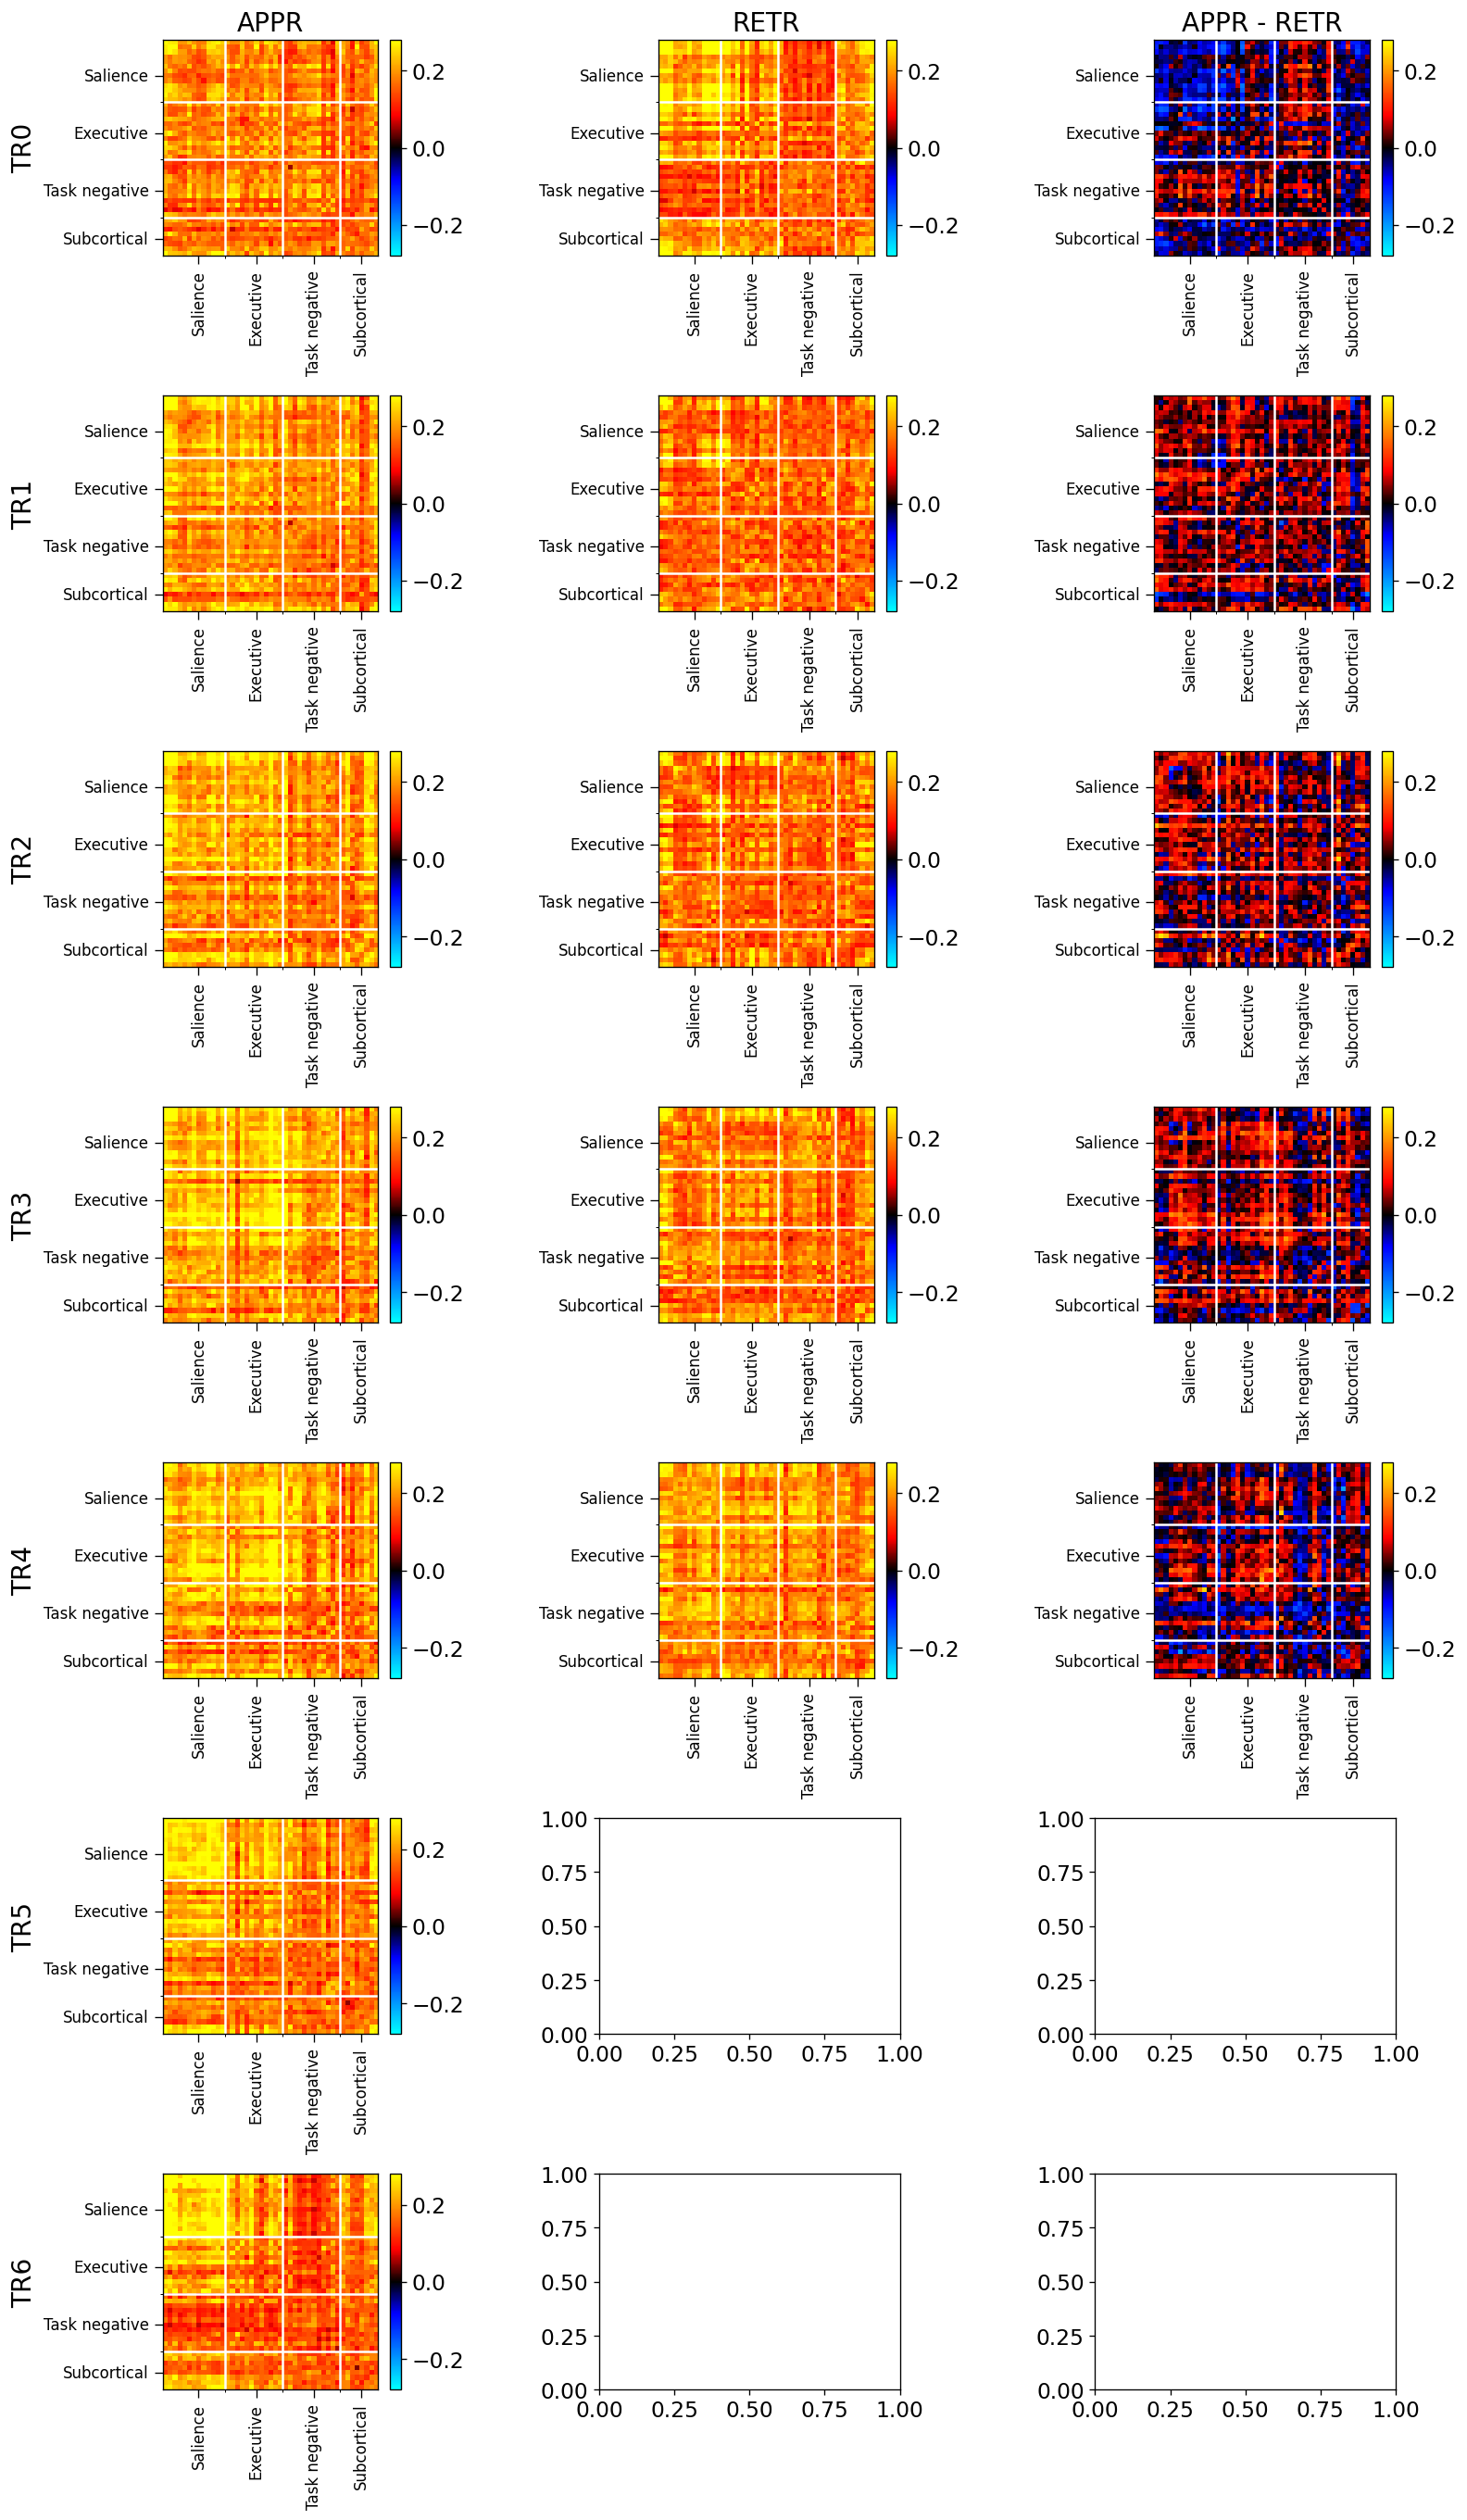

In [9]:
cvals  = [-2., -0.6, 0, 0.6, 2]
colors = ["cyan","blue","black","red","yellow"]
import matplotlib
import matplotlib.pyplot as plt
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
plot_iscs(args, pos_iscs, cmap=mycmap)
# plot_iscs(args, iscs)

In [10]:
# within- and between-network weight
args.nw_roi_idxs = {}
vals = np.cumsum(args.ticks)
for idx, (nw, nrois) in enumerate(zip(args.major_tick_labels, vals)):
    s = 0 if idx == 0 else vals[idx-1]
    args.nw_roi_idxs[nw] = args.roi_idxs[s:vals[idx]]

def get_nw_weights(args, iscs):
    nw_weights = {}
    for name in args.NAMES:
        nw_weights[name] = {}
        for idx1, nw1 in enumerate(args.major_tick_labels):
            nw_weights[name][nw1] = {}
            for idx2, nw2 in enumerate(args.major_tick_labels):
                if idx1 > idx2: continue
                nw_weights[name][nw1][nw2] = []

                for tr in range(args.MIN_TRS[name]):
                    block = f"{name}_TR{tr}"
                    vals = iscs[block][np.ix_(args.nw_roi_idxs[nw1], args.nw_roi_idxs[nw2])]
                    nw_weights[name][nw1][nw2].append(np.sum(vals) / vals.size) # * (vals > 0)

    return nw_weights

nw_weights = get_nw_weights(args, pos_iscs)

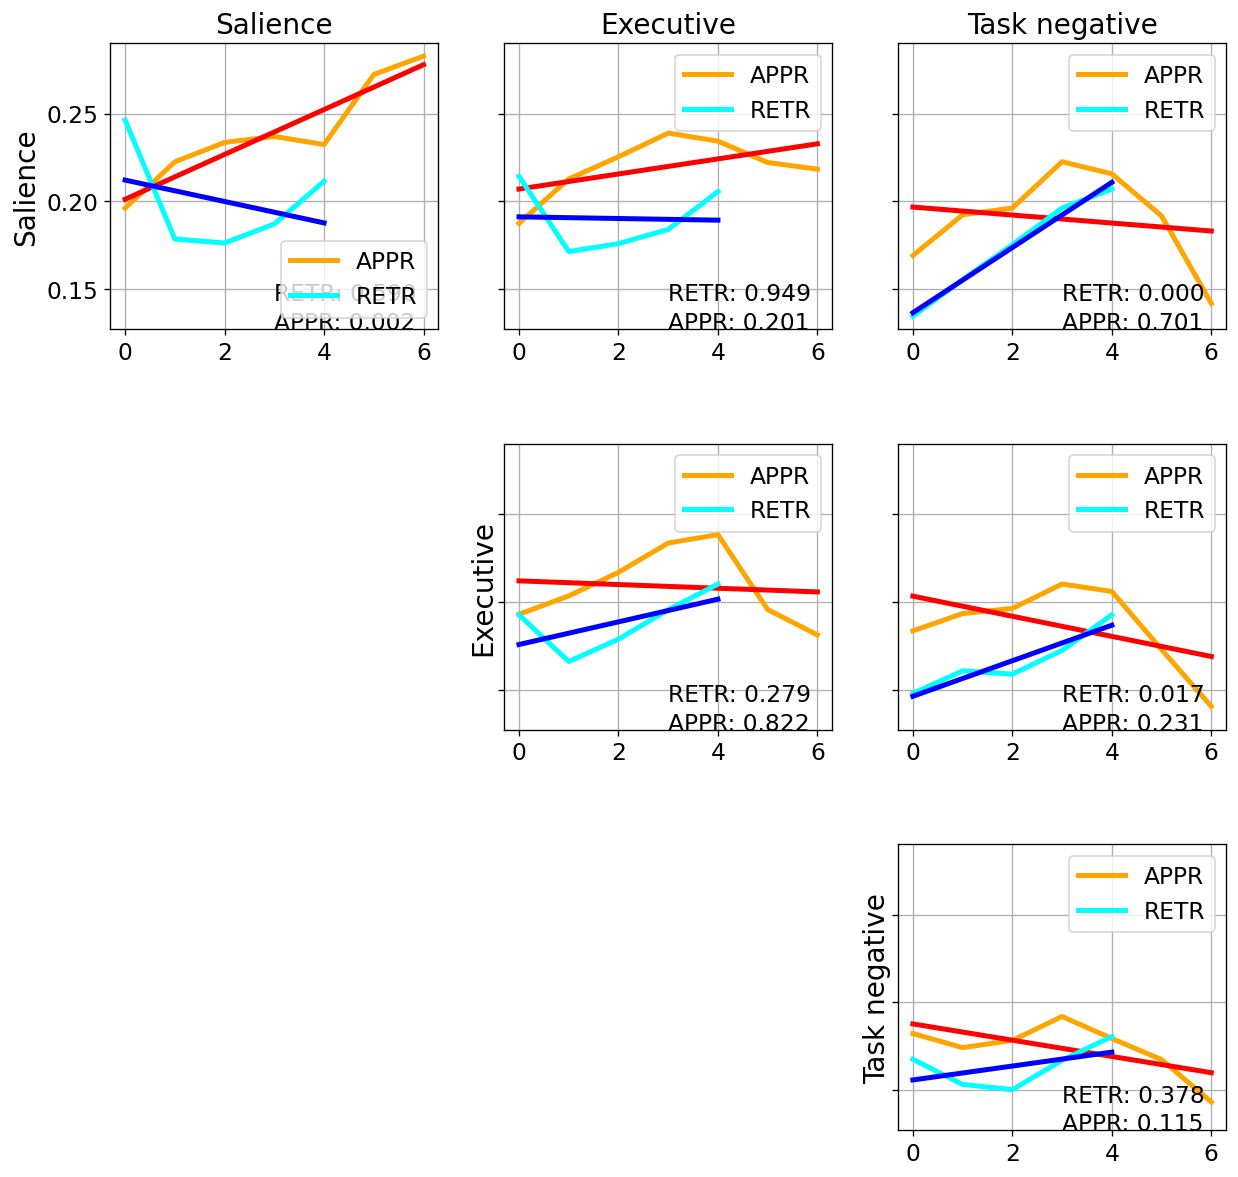

In [11]:
def plot_nw_weights(args, nw_weights, ):

    nrows, ncols = [len(args.major_tick_labels[:-1])] * 2
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(4*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.4
    )

    for idx1, nw1 in enumerate(args.major_tick_labels[:-1]):
        for idx2, nw2 in enumerate(args.major_tick_labels[:-1]):

            if idx1 > idx2: 
                axs[idx1, idx2].remove()
                continue

            ax = axs[idx1, idx2]

            for idx, name in enumerate(args.NAMES):
                y = nw_weights[name][nw1][nw2]
                ax.plot(
                    np.arange(len(y)),
                    y,
                    color=args.plot_colors[name],
                    linewidth=3,
                    label=name
                )

                m, c, r, p, se = sp.stats.linregress(np.arange(len(y)), y)
                ax.plot(
                    m * range(len(y)) + c,
                    color=args.linreg_colors[name],
                    linewidth=3,
                    # label=f"lr_{name[0]}"
                )
                ax.text(0.5, idx/10, f"{name}: {p:.3f}", transform=ax.transAxes)

            if idx1 == 0: ax.set_title(f"{nw2}")
            if idx2 == idx1: ax.set_ylabel(f"{nw1}", size='large')
            ax.legend()
            ax.grid(True)

args.plot_colors = {'APPR': 'orange', 'RETR': 'cyan'}
args.linreg_colors = {'APPR': 'red', 'RETR': 'blue'}
plot_nw_weights(args, nw_weights)

**discussion**
group ISC matrices look as expected!

In [33]:
# check the durations of appr and retr segments
from scipy import signal
def get_emo2_near_miss_windows(args, subj, motion_df, trial_lens):
    subj_motion_df = motion_df.loc[motion_df.pid.isin([subj])]
    proximity = np.hstack(
        subj_motion_df['proximity'].to_list()
    ).T
    direction = np.hstack(
        subj_motion_df['direction'].to_list()
    ).T
    ts = np.loadtxt(
        f"{args.main_data_dir}/CON{subj}/CON{subj}_resids_REML.1D"
    ).T
    
    assert (proximity.shape[0] == ts.shape[0])
    assert (np.sum(np.isnan(ts)) == 0)

    # censor proximity values 
    censor_TRs = ts[:,0] == 0
    proximity[censor_TRs] = 0.0

    # near misses
    near_miss_peaks, props = signal.find_peaks(
        proximity, 
        height=args.near_miss_thresh, 
        width=args.near_miss_width
    )

    near_miss_windows = np.round(
        np.stack(
            [props['left_ips'], props['right_ips']], 
            axis=-1
            )
    ).astype(int)

    near_misses = np.zeros_like(proximity)
    for idx in range(near_miss_windows.shape[0]):
        near_misses[near_miss_windows[idx, 0] : near_miss_windows[idx, 1]+1] = 1.0
        # +1 because we need the last TR also

    for (label, name) in zip(args.LABELS, args.NAMES):
        trials = dataset_utils.contiguous_regions((direction == label) * (near_misses))
        trial_lens[name] += list(trials[:, 1] - trials[:, 0])

    return trial_lens

trial_lens = {name:[] for name in args.NAMES}
for subj in tqdm(args.subjects):
    trial_lens = get_emo2_near_miss_windows(args, subj, motion_df, trial_lens)

  0%|          | 0/122 [00:00<?, ?it/s]

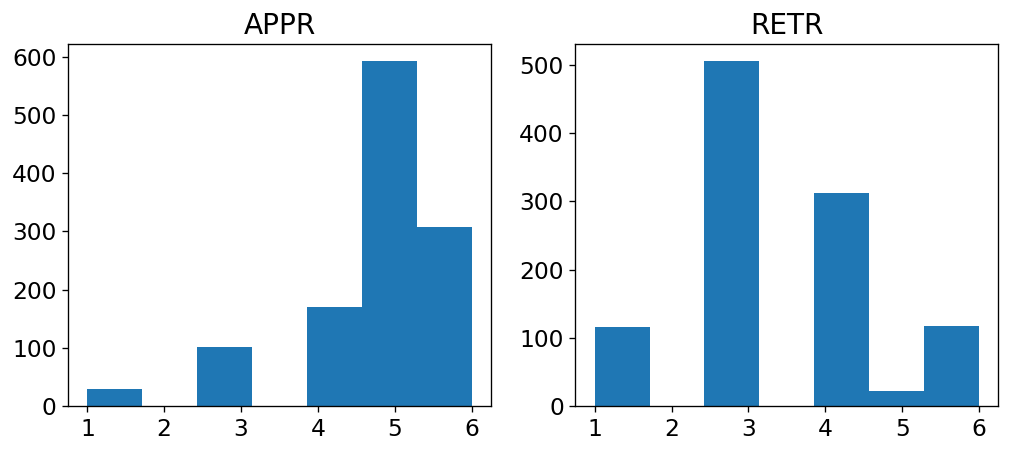

In [37]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx, name in enumerate(trial_lens.keys()):
    ax = axs[idx]
    ax.hist(trial_lens[name], bins=7)
    ax.set_title(name)